Aktywacja wymaganych paczek

In [1]:
import os
import scanpy as sc
from scipy.stats import median_abs_deviation
import anndata as ad
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import skimage 
import harmonypy as hm

Przygotowanie środowsika [Ustalenie miejsca zapisu plików, obrazów, wykresów oraz konfiguracja logu]

In [2]:
logging.basicConfig(filename=f"C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\mainlog.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
def set_up(output_path: str):
    image_path = os.path.join(output_path, "Images")
    os.makedirs(image_path, exist_ok=True)
    sc.settings.figdir = image_path

    sc.settings.set_figure_params(dpi=100, facecolor="white")

In [5]:
output_path = "C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results"
set_up(output_path)

In [5]:
def log_information(log_text: str):
    """
    Logs the information as well as prints it in console
    """
    logging.info(log_text)
    print(log_text)


def get_ann(input_path: str) -> ad.AnnData:
    """
    Fetches AnnData from a specified file

    input_path: path to the AnnData file
    """
    try:
        logging.info(f"Retrieving anndata from: {input_path}")
        adata = ad.read_h5ad(input_path)
        log_information(f"Successfully retrieved anndata from: {input_path}")
        return adata
    except OSError as e:
        logging.error(f"An error occurred while retrieving {input_path}: {e}")
        raise
    except Exception as e:
        logging.error(f"An unexpected error occurred while retrieving {input_path}: {e}")
        raise


def check_ann(adata: ad.AnnData):
    """
    Gives basic information about AnnData file

    Used for debugging purposes, or to check if the file has the expected data
    """
    try:
        logging.info(f"Retrieving information about .h5ad file")

        n_obs = adata.shape[0]
        n_var = adata.shape[1]

        print("Number of observations (cells):", n_obs)
        print("Number of variables (genes):", n_var)

        if hasattr(adata, 'var') and hasattr(adata.var, 'keys'):
            print("Available variables (annotations):", adata.var.keys())
        else:
            logging.warning("No variable annotations available.")

        if hasattr(adata, 'obs'):
            print("Top 5 available observations (annotations):", adata.obs.head(5))
        else:
            logging.warning("No observation annotations available.")

    except Exception as e:
        logging.error(f"An error occurred when retrieving information from .h5ad file: {e}")


Informacja o zawartości pliku merged.h5ad [Aka plik przed kontrolą jakości, zawierający polączenie wszystkich próbek (sample) z eksperymentu "GSE173706"]

In [5]:
adata = get_ann("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\merged.h5ad")
check_ann(adata)

Successfully retrieved anndata from: C:\Users\Julia\Desktop\scrna\dane\Results\merged.h5ad
Number of observations (cells): 96088
Number of variables (genes): 33538
Available variables (annotations): Index([], dtype='object')
Top 5 available observations (annotations):                                                      sample      batch  \
GSM5277170_NS-AR001_AAACGAACACCCTTGT-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAACGAAGTCTTTATC-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAAGAACCATTAGGAA-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAAGGATAGGTTCCAT-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAAGGATTCTTAGGAC-1  GSM5277170_NS-AR001  GSE173706   

                                         patient tissue   status condition  \
GSM5277170_NS-AR001_AAACGAACACCCTTGT-1  NS-AR001   Skin  Healthy    Normal   
GSM5277170_NS-AR001_AAACGAAGTCTTTATC-1  NS-AR001   Skin  Healthy    Normal   
GSM5277170_NS-AR001_AAAGAACCATTAGGAA-1  NS-AR001   S

Przeprowadzenie kotroli jakości i przygotowanie do filtorwania

In [3]:
def is_outlier(adata, metric, nmads):
    met = adata.obs[metric]
    outlier = (met < np.median(met) - nmads * median_abs_deviation(met)) | (
        np.median(met) + nmads * median_abs_deviation(met) < met
    )
    return outlier


def quality_check(input_path: str, output_path: str) -> str:
    """
    Annotates mitochondrial genes and performs a quality check

    input_path: Path to the folder containing the 10x Genomics data.
    output_path: Path to the folder where the h5ad file and QC plot will be saved.

    :return: Path to the saved h5ad file.
    """

    if not os.path.exists(input_path):
        logging.error(f"Input path does not exist: {input_path}")
        raise

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    try:
        file_name = os.path.basename(input_path.rstrip('/'))
        log_information(f"Pre-processing file: {file_name}")

        # Annotate mitochondrial genes
        adata = sc.read_h5ad(input_path)
        mito_genes = [gene for gene in adata.var_names if gene.lower().startswith(('mt-', 'mito-'))]
        adata.var["mt"] = adata.var_names.isin(mito_genes)

        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)

        # Mark genes as outliers
        adata.obs["outlier"] = (
                is_outlier(adata, "log1p_total_counts", 5)
                | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        )
        adata.obs.outlier.value_counts()

        log_information(f"Outliers found: {adata.obs['outlier'].sum()} cells")

        # Save results
        output_path = os.path.join(output_path, f"qc.h5ad")
        sc.write(output_path, adata)

        # Visualise the results
        plt.figure(figsize=(8, 6))
        sns.histplot(adata.obs["total_counts"], bins=100, kde=False)
        plt.title("Histogram of Total Counts")
        plt.xlabel("Total Counts")
        plt.ylabel("Frequency")
        hist_path = os.path.join(image_path, "total_counts_histogram.png")
        plt.savefig(hist_path)
        plt.show()
        plt.close()

        sc.pl.violin(adata, "pct_counts_mt", save="_plot.png")
        sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt", save="_plot.png")

        log_information(f"Successfully processed file: {file_name}")

        return output_path

    except Exception as e:
        logging.error(f"An error occurred while pre-processing {input_path}: {e}")

Pre-processing file: merged.h5ad
Outliers found: 3117 cells


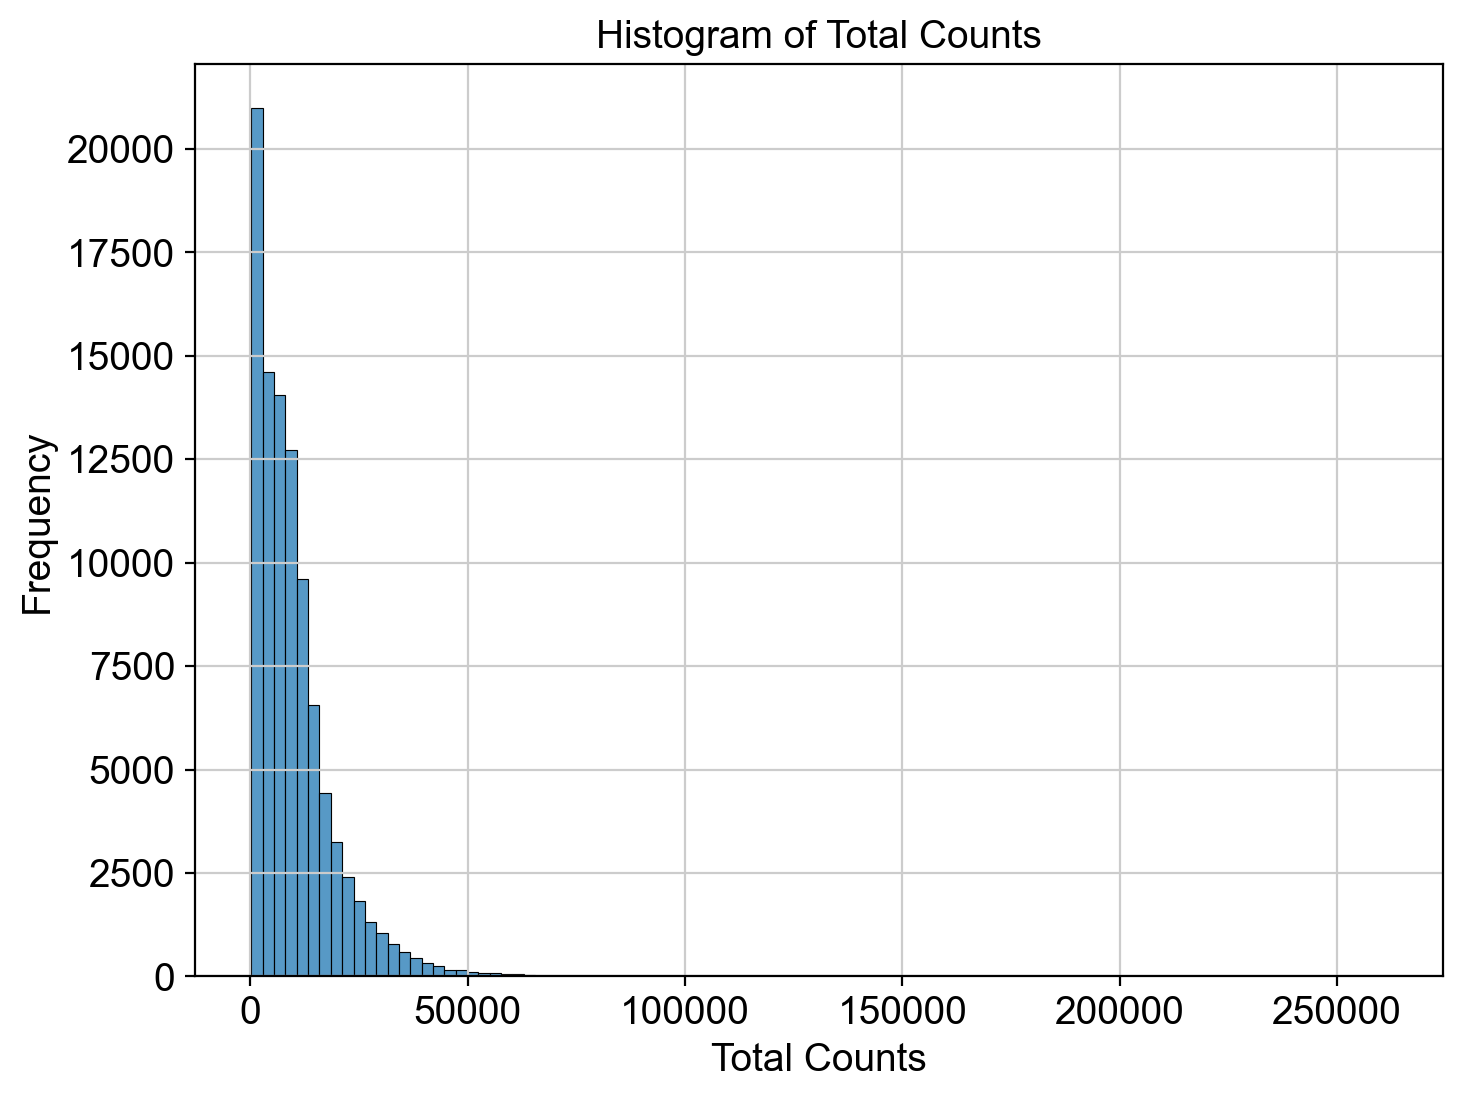

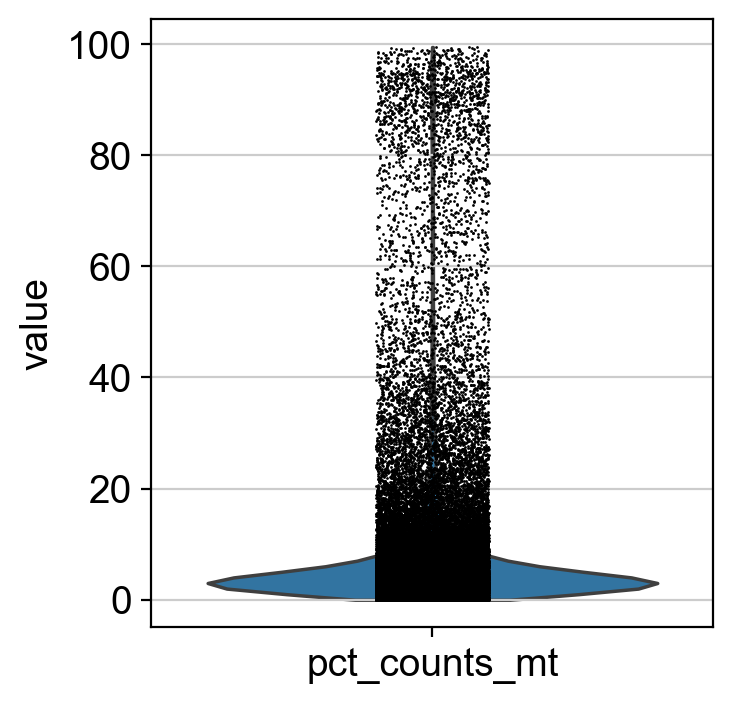

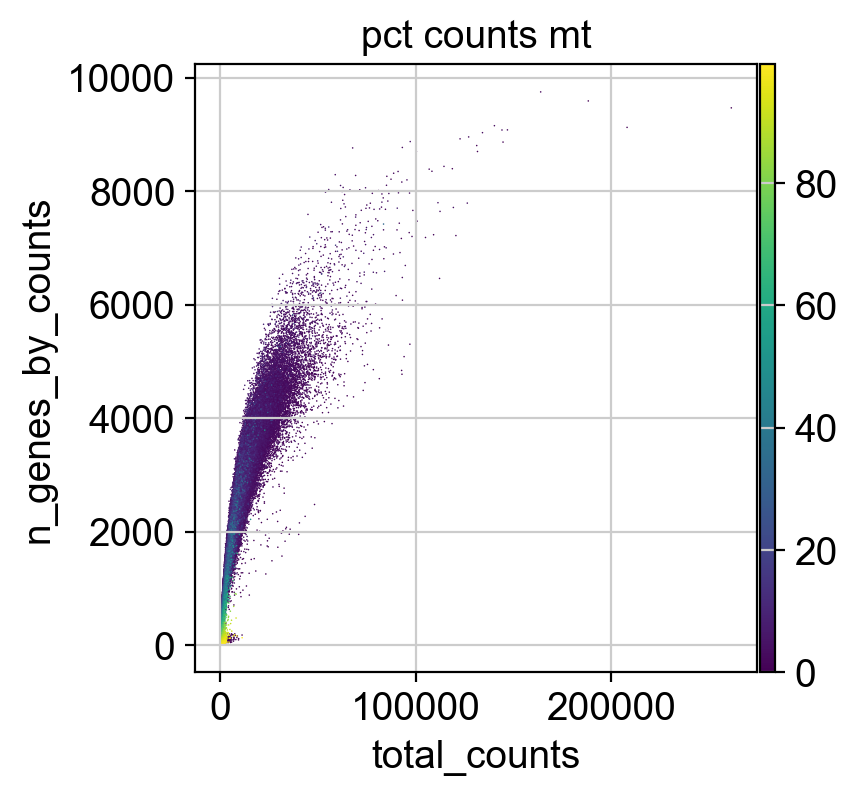

Successfully processed file: merged.h5ad


'C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\qc.h5ad'

In [6]:
quality_check("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\merged.h5ad",output_path)

In [7]:
adata = get_ann("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\qc.h5ad")
check_ann(adata)

Successfully retrieved anndata from: C:\Users\Julia\Desktop\scrna\dane\Results\qc.h5ad
Number of observations (cells): 96088
Number of variables (genes): 33538
Available variables (annotations): Index(['mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'],
      dtype='object')
Top 5 available observations (annotations):                                                      sample      batch  \
GSM5277170_NS-AR001_AAACGAACACCCTTGT-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAACGAAGTCTTTATC-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAAGAACCATTAGGAA-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAAGGATAGGTTCCAT-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAAGGATTCTTAGGAC-1  GSM5277170_NS-AR001  GSE173706   

                                         patient tissue   status condition  \
GSM5277170_NS-AR001_AAACGAACACCCTTGT-1  NS-AR001   Skin  Healthy    Normal 

Kolejnym krokiem po wykonaniu kontroli jakości jest odfiltrowanie komórek/genów które nie spelniają wymagań

In [8]:
def filter(adata: ad.AnnData, output_path: str) -> str:
    """
    Filters the AnnData object based on given criteria and saves it post filtering.

    adata: AnnData object.
    output_path: Path to save the filtered AnnData object.

    :return: Path to the saved filtered AnnData object.
    """
    min_cell = 3
    max_cell = 0
    min_genes = 200
    max_genes = 6000
    mito = 15

    logging.info(f"Filtering cells with parameters: \n min_cell = {min_cell} \n max_cell = {max_cell} \n min_genes = {min_genes} \n max_genes = {max_genes}, mitochondrial% = {mito}")

    try:
        log_information(f"Filtering AnnData")
        log_information(f"Number of cells: {adata.n_obs} before filtering")
        log_information(f"Number of genes: {adata.n_vars} before filtering")

        output_path = os.path.join(output_path, f"filtered.h5ad")

        if min_cell > 0:
            sc.pp.filter_genes(adata, min_cells=min_cell)
            print(f"Number of genes after filtering out ones that appear in less then {min_cell} cells: {adata.n_vars}")

        if max_cell > 0:
            sc.pp.filter_genes(adata, max_cells=max_cell)
            print(f"Number of genes after filtering out ones that appear in more then {max_cell} cells: {adata.n_vars}")

        if min_genes > 0:
            sc.pp.filter_cells(adata, min_genes=min_genes)
            print(f"Number of cells after filtering out ones with less then {min_genes} genes: {adata.n_obs}")

        if max_genes > 0:
            sc.pp.filter_cells(adata, max_genes=max_genes)
            print(f"Number of cells after filtering out ones with more then {max_genes} genes: {adata.n_obs}")

        if mito > 0:
            if 'pct_counts_mt' not in adata.obs.columns:
                raise ValueError("'pct_counts_mt' column is missing in adata.obs")

            adata.obs["mt_outlier"] = (
                    is_outlier(adata, "pct_counts_mt", 3)
                    | (adata.obs["pct_counts_mt"] > mito)
            )

            adata = adata[(~adata.obs.outlier) & (~adata.obs["mt_outlier"])].copy()
            print(f"Number of cells after filtering of low quality cells ( including outliers ): {adata.n_obs}")

        if os.path.exists(output_path):
            base_name, ext = os.path.splitext(output_path)
            count = 1
            while os.path.exists(f"{base_name}_{count}{ext}"):
                count += 1
            output_path = f"{base_name}_{count}{ext}"
            sc.write(output_path, adata)
        else:
            sc.write(output_path, adata)

        log_information(f"AnnData filtered successfully")

        return output_path

    except Exception as e:
        logging.error(f"An error occurred while filtering AnnData: {e}")
        raise

In [9]:
adata = get_ann("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\qc.h5ad")
filter(adata, output_path)

Successfully retrieved anndata from: C:\Users\Julia\Desktop\scrna\dane\Results\qc.h5ad
Filtering AnnData
Number of cells: 96088 before filtering
Number of genes: 33538 before filtering
Number of genes after filtering out ones that appear in less then 3 cells: 26268
Number of cells after filtering out ones with less then 200 genes: 93831
Number of cells after filtering out ones with more then 6000 genes: 93407
Number of cells after filtering of low quality cells ( including outliers ): 79747
AnnData filtered successfully


'C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\filtered.h5ad'

Zaprezentowanie rezultatów filtrowania

Successfully retrieved anndata from: C:\Users\Julia\Desktop\scrna\dane\Results\filtered.h5ad
Number of observations (cells): 79747
Number of variables (genes): 26268
Available variables (annotations): Index(['mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'n_cells'],
      dtype='object')
Top 5 available observations (annotations):                                                      sample      batch  \
GSM5277170_NS-AR001_AAAGGATAGGTTCCAT-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAAGTCCTCGACGTCG-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAATGGAAGCTAGAGC-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AACAAAGTCACACCGG-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AACAAGACAAATGGTA-1  GSM5277170_NS-AR001  GSE173706   

                                         patient tissue   status condition  \
GSM5277170_NS-AR001_AAAGGATAGGTTCCAT-1  NS-AR001   

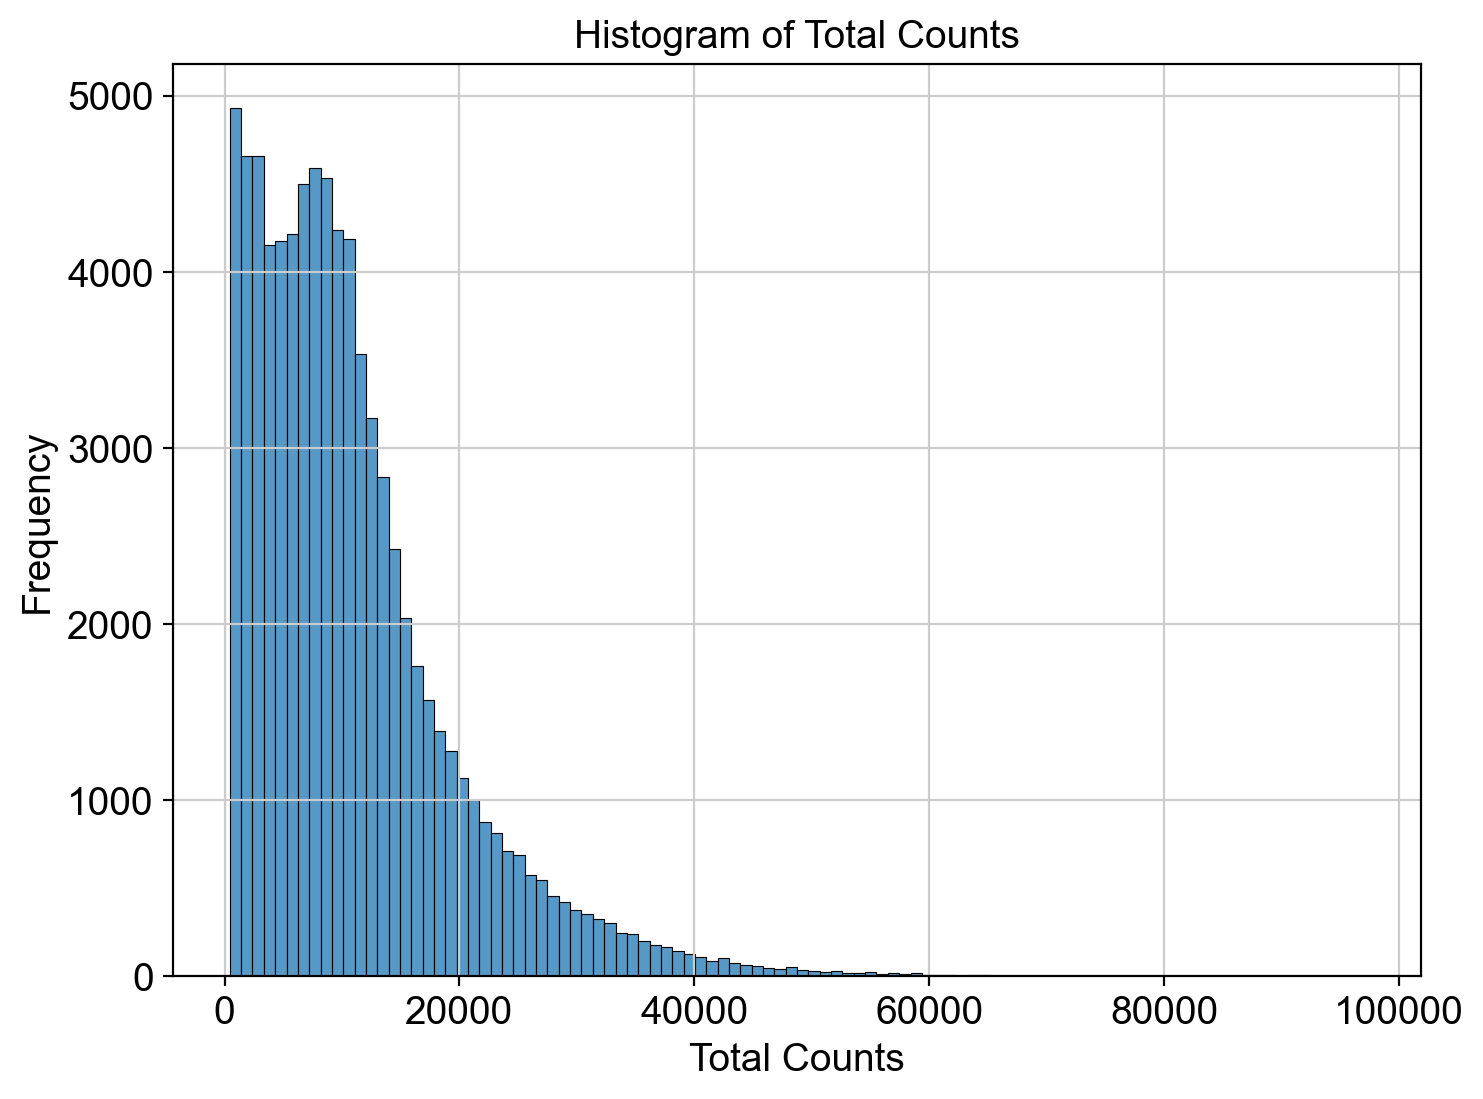

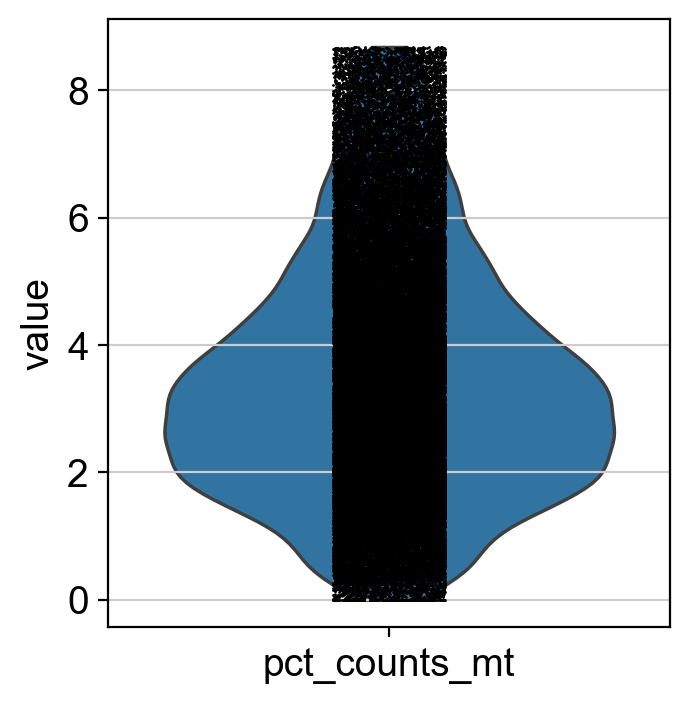

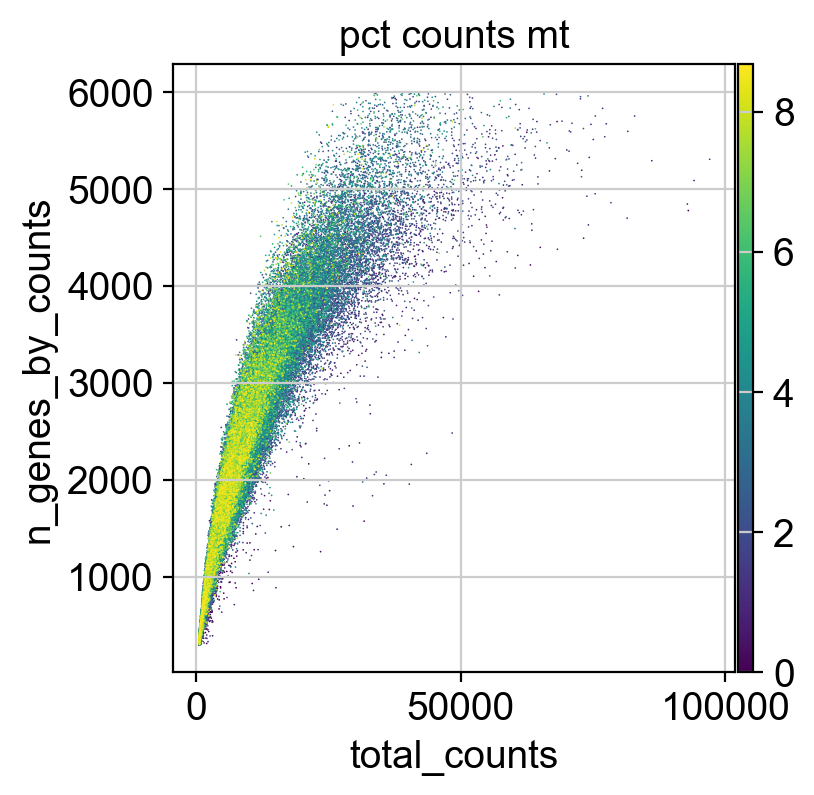

In [11]:
adata = get_ann("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\filtered.h5ad")
check_ann(adata)

plt.figure(figsize=(8, 6))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False)
plt.title("Histogram of Total Counts")
plt.xlabel("Total Counts")
plt.ylabel("Frequency")
hist_path = os.path.join(image_path, "total_counts_histogram_post_filtering.png")
plt.savefig(hist_path)
plt.show()
plt.close()

sc.pl.violin(adata, "pct_counts_mt", save="_plot_post_filtering.png")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt", save="_plot_post_filtering.png") 

In [ ]:
Kolejnym krokiem analizy scRNA-seq jest normalizacja

In [6]:
def normalize(adata: ad.AnnData, output_path: str) -> str:
    """
    Normalizes and logarithmizes, the AnnData object
    Detects doublets and highly variable genes in AnnData object then saves it.

    adata: AnnData object.
    output_path: Path to save the normalized AnnData object.
    :return: Path to the saved normalized AnnData object.
    """
    try:
        log_information(f"Normalizing AnnData")

        sc.pp.scrublet(adata)
        adata.layers["counts"] = adata.X.copy()
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, batch_key="sample")

        output_path = os.path.join(output_path, f"normalized.h5ad")
        sc.write(output_path, adata)

        log_information(f"AnnData normalized successfully")

        return output_path

    except Exception as e:
        logging.error(f"An error occurred while normalizing AnnData: {e}")
        raise

In [7]:
adata = get_ann("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\filtered.h5ad")
normalize(adata, output_path)

Successfully retrieved anndata from: C:\Users\Julia\Desktop\scrna\dane\Results\filtered.h5ad
Normalizing AnnData
AnnData normalized successfully


'C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\normalized.h5ad'

In [8]:
adata = get_ann("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\normalized.h5ad")
check_ann(adata)

Successfully retrieved anndata from: C:\Users\Julia\Desktop\scrna\dane\Results\normalized.h5ad
Number of observations (cells): 79747
Number of variables (genes): 26268
Available variables (annotations): Index(['mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'n_cells', 'highly_variable', 'means', 'dispersions',
       'dispersions_norm', 'highly_variable_nbatches',
       'highly_variable_intersection'],
      dtype='object')
Top 5 available observations (annotations):                                                      sample      batch  \
GSM5277170_NS-AR001_AAAGGATAGGTTCCAT-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAAGTCCTCGACGTCG-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAATGGAAGCTAGAGC-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AACAAAGTCACACCGG-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AACAAGACAAATGGTA-1  GSM5277170_NS-AR001  GSE1

Następnie wykonano redukcję wymiarów metodą PCA oraz UMAP

In [9]:
def reduce_dimensions(adata: ad.AnnData, output_path: str) -> str:
    """
    Reduces dimensions of the AnnData object and saves it.

    adata: AnnData object.
    output_path: Path to save the reduced dimension AnnData object.
    :return: Path to the saved reduced dimension AnnData object.
    """
    try:
        log_information(f"Reducing dimensions of AnnData")

        sc.pp.pca(adata)
        sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)
        sc.pl.umap(adata, size=2, color=["sample"], save="_dimension_reduction.png")

        output_path = os.path.join(output_path, f"pca_umap.h5ad")
        sc.write(output_path, adata)

        log_information(f"Dimensions reduced successfully")

        return output_path

    except Exception as e:
        logging.error(f"Reducing dimensions failed: {e}")
        raise

Successfully retrieved anndata from: C:\Users\Julia\Desktop\scrna\dane\Results\normalized.h5ad
Reducing dimensions of AnnData


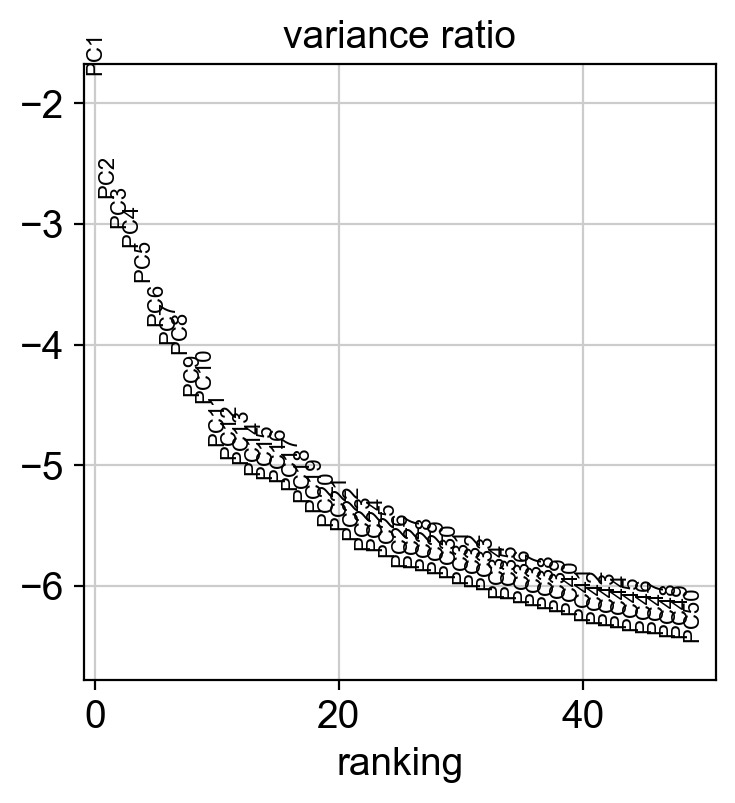

c:\Users\Julia\anaconda3\envs\scrnaseq\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


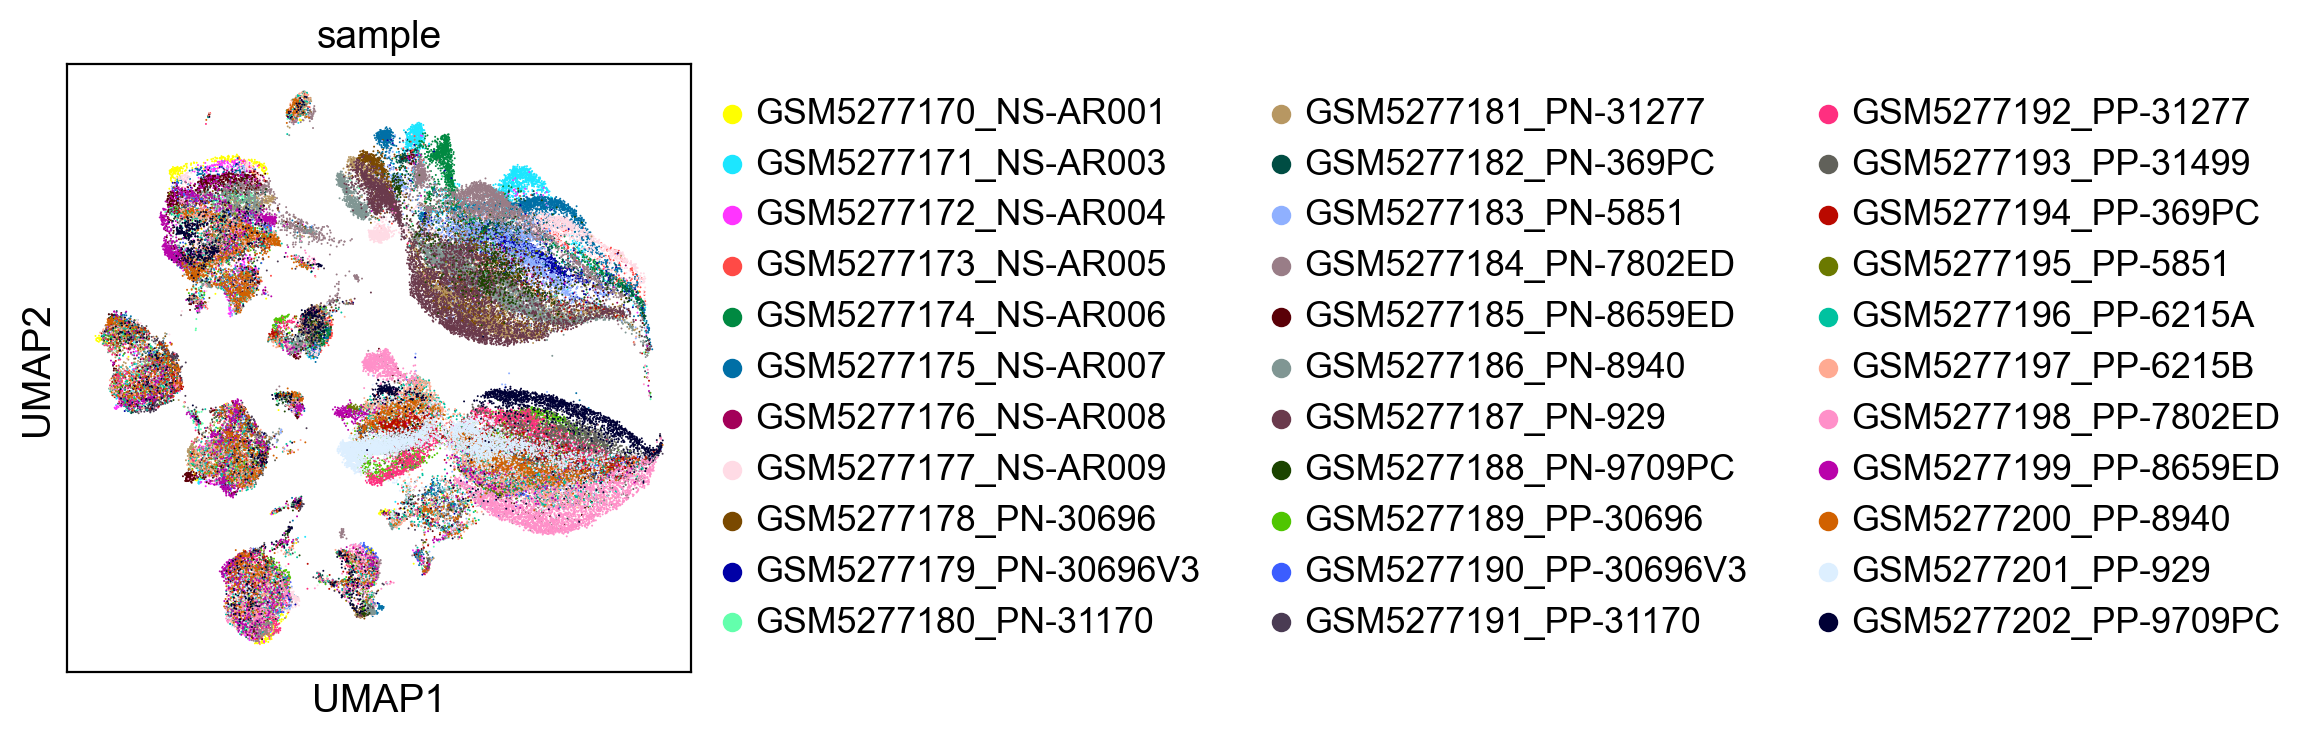

Dimensions reduced successfully


'C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\pca_umap.h5ad'

In [11]:
adata = get_ann("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\normalized.h5ad")
reduce_dimensions(adata, output_path)

In [12]:
adata = get_ann("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\pca_umap.h5ad")
check_ann(adata)

Successfully retrieved anndata from: C:\Users\Julia\Desktop\scrna\dane\Results\pca_umap.h5ad
Number of observations (cells): 79747
Number of variables (genes): 26268
Available variables (annotations): Index(['mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'n_cells', 'highly_variable', 'means', 'dispersions',
       'dispersions_norm', 'highly_variable_nbatches',
       'highly_variable_intersection'],
      dtype='object')
Top 5 available observations (annotations):                                                      sample      batch  \
GSM5277170_NS-AR001_AAAGGATAGGTTCCAT-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAAGTCCTCGACGTCG-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AAATGGAAGCTAGAGC-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AACAAAGTCACACCGG-1  GSM5277170_NS-AR001  GSE173706   
GSM5277170_NS-AR001_AACAAGACAAATGGTA-1  GSM5277170_NS-AR001  GSE173

Następnie przygotowano drugą wersję analizy z uwzględnieniem integracji

In [22]:
def reduce_dimensions_hm(adata: ad.AnnData, output_path: str) -> str:
    """
    Reduces dimensions of the AnnData object and saves it.

    adata: AnnData object.
    output_path: Path to save the reduced dimension AnnData object.
    :return: Path to the saved reduced dimension AnnData object.
    """
    try:
        log_information(f"Reducing dimensions of AnnData using Harmony")

        sc.pp.pca(adata, n_comps=50)  
        sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

        temp = hm.run_harmony(adata.obsm["X_pca"],adata.obs,["sample"])
        adata.obsm["X_harmony"] = temp.Z_corr.T
        sc.pp.neighbors(adata, n_pcs=30, use_rep="X_harmony")
        sc.tl.umap(adata)
        sc.pl.umap(adata, size=2, color=["sample"], save="_dimension_reduction_hm.png")

        output_path = os.path.join(output_path, "pca_umap_hm.h5ad")
        sc.write(output_path, adata)

        log_information(f"Dimensions reduced successfully using Harmony integration")

        return output_path

    except Exception as e:
        logging.error(f"Reducing dimensions failed: {e}")
        raise

In [13]:
output_path = "C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results_Merged"
set_up(output_path)

Successfully retrieved anndata from: C:\Users\Julia\Desktop\scrna\dane\Results\normalized.h5ad
Reducing dimensions of AnnData using Harmony


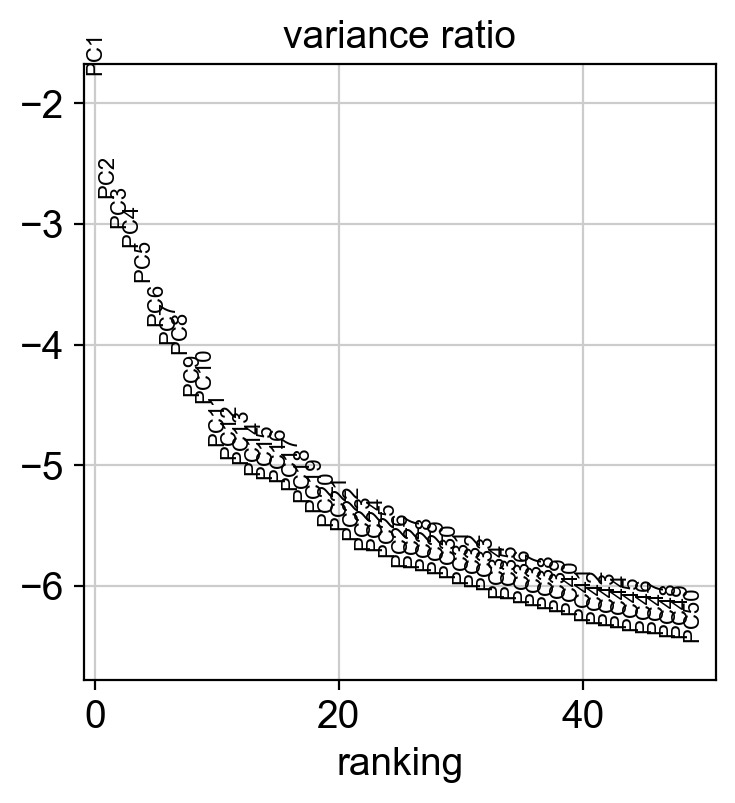

2025-01-28 02:49:14,523 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-28 02:49:22,345 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-28 02:49:22,601 - harmonypy - INFO - Iteration 1 of 10
2025-01-28 02:49:40,679 - harmonypy - INFO - Iteration 2 of 10
2025-01-28 02:49:58,938 - harmonypy - INFO - Iteration 3 of 10
2025-01-28 02:50:16,914 - harmonypy - INFO - Iteration 4 of 10
2025-01-28 02:50:34,956 - harmonypy - INFO - Iteration 5 of 10
2025-01-28 02:50:53,015 - harmonypy - INFO - Iteration 6 of 10
2025-01-28 02:51:11,245 - harmonypy - INFO - Iteration 7 of 10
2025-01-28 02:51:29,321 - harmonypy - INFO - Iteration 8 of 10
2025-01-28 02:51:47,339 - harmonypy - INFO - Iteration 9 of 10
2025-01-28 02:52:01,166 - harmonypy - INFO - Iteration 10 of 10
2025-01-28 02:52:12,944 - harmonypy - INFO - Stopped before convergence
c:\Users\Julia\anaconda3\envs\scrnaseq\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please u

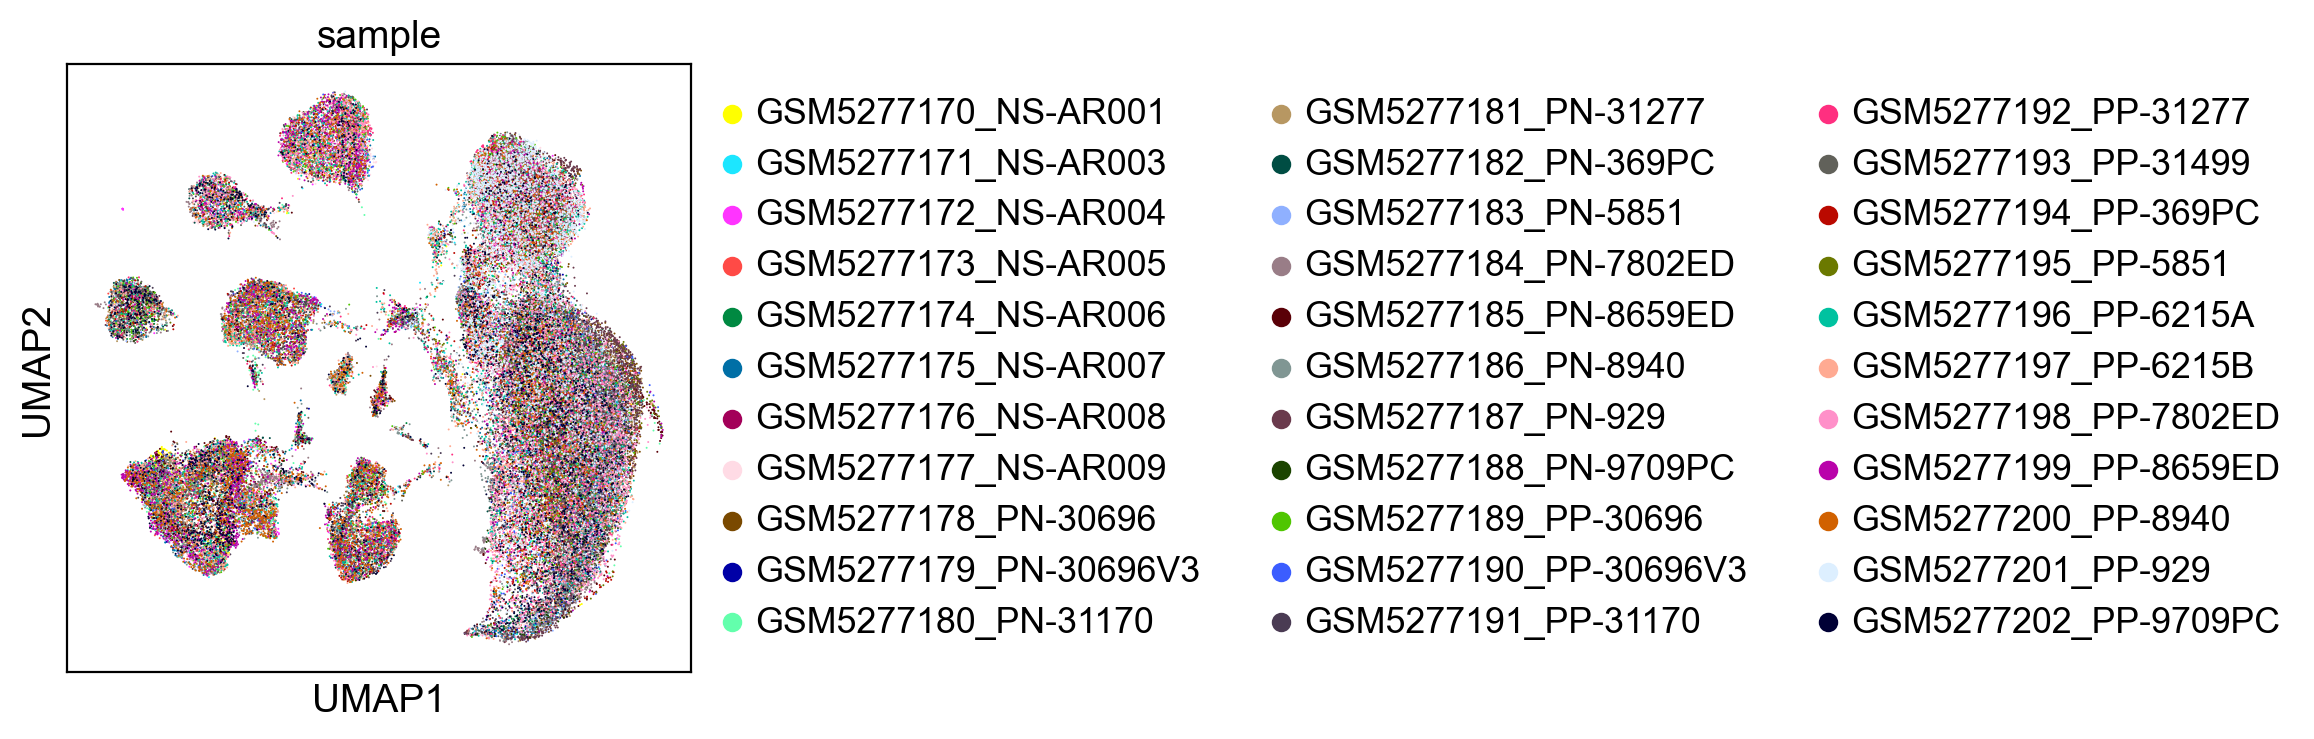

Dimensions reduced successfully using Harmony integration


'C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results_Merged\\pca_umap_hm.h5ad'

In [23]:
adata = get_ann("C:\\Users\\Julia\\Desktop\\scrna\\dane\\Results\\normalized.h5ad")
reduce_dimensions_hm(adata, output_path)